# Проект по А/B-тестированию

Необходимо оценить корректность проведения А/B-теста пользователей международного интернет-магазина.
На входе имеется ТЗ:
- Название теста: recommender_system_test;
- Группы: А (контрольная), B (новая платёжная воронка);
- Дата запуска: 2020-12-07;
- Дата остановки набора новых пользователей: 2020-12-21;
- Дата остановки: 2021-01-04;
- Аудитория: 15% новых пользователей из региона EU;
- Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- Ожидаемое количество участников теста: 6000.
- Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%: 
    * конверсии в просмотр карточек товаров — событие product_page
    * просмотры корзины — product_card
    * покупки — purchase.   

## Исследование данных

Импортируем необходимые библиотеки и загрузим данные.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
import math as mth
from scipy import stats as st
from matplotlib.pyplot import figure
%matplotlib inline
pd.options.mode.chained_assignment = None

my_palette = ['#feebe2', '#fcc5c0', '#fa9fb5', '#f768a1', '#c51b8a', '#7a0177']

In [2]:
ab_project = pd.read_csv('/datasets/ab_project_marketing_events.csv') # календарь маркетинговых событий
new_users = pd.read_csv('/datasets/final_ab_new_users.csv') #  все пользователи, зарегистрировавшиеся в интернет-магазине
events = pd.read_csv('/datasets/final_ab_events.csv') # все события новых пользователей 
participants = pd.read_csv('/datasets/final_ab_participants.csv') # таблица участников тестов

Посмотрим по каждой таблице пример данных, размерность таблицы, типы данных, наличие пропусков и дубликаты. Для этого напишем функцию df().

In [3]:
# уберем перенос строки
pd.options.display.expand_frame_repr = False

# анализ данных на типы данных, пропуски и дубликаты:
def df(df):
    
    """ Функция по предобработке данных  """
    
    print('Пример данных таблицы:\n%s\n\n'
          'Типы строк таблицы:\n%s\n\n' 
          'Кол-во пропусков в таблице:\n%s\n\n'
          'Кол-во дубликатов в таблице:\n%s\n\n' % (df.sample(3), 
                                                    df.dtypes, 
                                                    df.isnull().sum(), 
                                                    df[df.duplicated(keep=False)].count()[0]))

In [4]:
for table in [ab_project, new_users, events, participants]:
    df(table)
    print('===================')

Пример данных таблицы:
                      name                   regions    start_dt   finish_dt
3             Easter Promo  EU, CIS, APAC, N.America  2020-04-12  2020-04-19
13   Chinese Moon Festival                      APAC  2020-10-01  2020-10-07
2   St. Patric's Day Promo             EU, N.America  2020-03-17  2020-03-19

Типы строк таблицы:
name         object
regions      object
start_dt     object
finish_dt    object
dtype: object

Кол-во пропусков в таблице:
name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

Кол-во дубликатов в таблице:
0


Пример данных таблицы:
                user_id  first_date     region   device
26064  46B31CFBA23AEA0D  2020-12-22       APAC      Mac
31932  813AC053ED2E772B  2020-12-23  N.America  Android
33174  DDBE6CC8FB13E5DE  2020-12-23  N.America  Android

Типы строк таблицы:
user_id       object
first_date    object
region        object
device        object
dtype: object

Кол-во пропусков в таблице:
user_id       0
first_d

Итого, необходимо поменять типы данных у всех колонок с датами, посмотреть пропуски в таблице с событиями. Дубликатов в таблицах нет.


Дополнительные данные о событиях есть только по закупкам (purchase) - стоимость покупки в долларах.

In [5]:
events[events.details.notna()].event_name.unique()

array(['purchase'], dtype=object)

Для всех столбцов с датами событий необходимо поставить соответствующий тип данных:

In [6]:
ab_project.start_dt = pd.to_datetime(ab_project.start_dt, format='%Y-%m-%d')
ab_project.finish_dt = pd.to_datetime(ab_project.finish_dt, format='%Y-%m-%d')
new_users.first_date = pd.to_datetime(new_users.first_date, format='%Y-%m-%d %H:%M')
events.event_dt = pd.to_datetime(events.event_dt, format='%Y-%m-%d %H:%M')

Итого, у нас есть данные о датах маркетинговых событиях, пользователи в интернет-магазине, их действия и принадлежность к группе для тестирования.

## Исследовательский анализ данных EDA

In [7]:
import warnings
warnings.filterwarnings("ignore")

Посмотрим данные для теста recommender_system_test. Соединим два датасета и выведем результат на графике ниже.

In [8]:
events_and_users = (events.merge(participants, left_on=['user_id'], right_on=['user_id'])
                          .query('ab_test == "recommender_system_test"'))

In [9]:
print('Всего в логе', events_and_users.event_name.nunique(), 'событий и', events_and_users.user_id.nunique(),'пользователей')

event_per_user = events_and_users.groupby('event_dt').agg({'user_id': ['count', 'nunique']})
event_per_user.columns = ['event', 'users']

print('В среднем на пользователя приходится ',round(event_per_user.event.sum() / event_per_user.users.sum(), 2),' событий')
print('Для анализа смотрим период с', events_and_users.event_dt.min(), 'по', events_and_users.event_dt.max())
print('При этом, для анализа есть пользователи из всех экспериментальных групп:', events_and_users.group.unique())

Всего в логе 4 событий и 3675 пользователей
В среднем на пользователя приходится  1.49  событий
Для анализа смотрим период с 2020-12-07 00:05:57 по 2020-12-30 12:42:57
При этом, для анализа есть пользователи из всех экспериментальных групп: ['A' 'B']


In [10]:
# Сколько пользователей в каждой экспериментальной группе? 
gr_count_user = (events_and_users.pivot_table(index='group', values='user_id', aggfunc=lambda x: x.nunique()))['user_id']
gr_count_user['all'] = gr_count_user.iloc[1] + gr_count_user.iloc[0]

print('Сколько пользователей в каждой группе?\n', gr_count_user)
print()
print('Количество пользователей групп отличаются друг от друга на', 
     round((gr_count_user.iloc[1]/gr_count_user.iloc[0] - 1)*100,2), '%')

Сколько пользователей в каждой группе?
 group
A      2747
B       928
all    3675
Name: user_id, dtype: int64

Количество пользователей групп отличаются друг от друга на -66.22 %


В группах очень большая разница между пользователями.

Посмотрим воронку событий: какие в ней есть шаги и с какой частотой встречаются по группам пользователей. Для отрисовки воронки напишем функцию hist().

In [11]:
def hist(data, title, xlabel, ylabel):
    fig, ax = plt.subplots(figsize=(10, 2))        # размер графика
    ax.barh(data.iloc[:,0], data.iloc[:,1], color= my_palette[4]) # горизонтальный bar по данным + задаем цвет
    ax.set_title(title, loc='left', pad=12, fontweight="bold")   # заголовок графика + задаем шрифт
    for s in ['top','bottom','left','right']:                    # убираю все границы графика
        ax.spines[s].set_visible(False)                          
    ax.grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.2)  # задаю только промежуточные границы по значениям
    for i in ax.patches:                                                     # цикл по значениям
        ax.text(i.get_width()+2, i.get_y()+0.5, str(round((i.get_width()), 2)),   # задаю отступ (+) для подписи
                fontsize=10, fontweight='bold', color='black')                     # задаю шрифт и цвет подписи значения
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show() 

Посмотрим, как распределены события, с какой частотой, а также конверсию пользователей на разных этапах вопронки по группам.

Напишем функцию analisys(), которая будет выводить графики и показывать:
* какие события в воронке и с какой частотой встречаются;
* распределение событий по дням;
* сколько пользователей совершили события;
* конверсия пользователей.

Перед тем, как строить воронку, укажем логический порядок действия пользователей: регистрация, просмотр карточек товара, просмотр корзины, покупка.

In [12]:
events_and_users['event_name'] = (events_and_users['event_name'].map({'login': '1_login', 
                                                                      'product_page': '2_product_page',
                                                                      'product_cart': '3_product_cart',
                                                                      'purchase': '4_purchase'})) 

In [13]:
def analisys(df):
# смотрим, какие были события и с какой частотой встречались
    events_per_type = (df.groupby('event_name')['event_dt']
                         .count()
                         .reset_index()
                         .sort_values(by='event_dt', ascending = False)
                         .rename({'event_name': 'event', 'event_dt': 'count_of_events'}, axis=1))

    hist(events_per_type.sort_values('event', ascending=False), 
         'Какие события есть в логах и с какой частотой втречаются?', 'количество событий', 'события')

# смотрим распредееление событий по дням    
    f, ax = plt.subplots(figsize=(15, 3))
    sns.distplot(df.event_dt, kde=False, bins=100, color = my_palette[3])
    plt.title('Распределение событий по дате', loc='left', pad=12, fontweight="bold")
    ax.set(ylabel="количество событий", xlabel="дата события")
    for s in ['top','bottom','left','right']:                   
        ax.spines[s].set_visible(False)                          
    ax.grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.2)
    
# смотрим, сколько пользователей совершили события?
    events_per_user = (df.groupby('event_name')
                         .agg({'user_id': 'nunique'})
                         .reset_index().sort_values(by='user_id', ascending = False)
                         .rename({'event_name': 'event', 'user_id': 'count_of_users'}, axis=1)) 

    hist(events_per_user.sort_values('event', ascending=False) ,'Сколько пользователей совершили события?', 
      'количество пользователей', 'события')
    
#  смотрим, какая доля пользователей перешло на следующий шаг
    events_per_user['unique_prev_step'] = events_per_user['count_of_users'].shift(1)

    events_per_user.loc[events_per_user['unique_prev_step'].isna(),'unique_prev_step'] = \
              events_per_user.loc[events_per_user['unique_prev_step'].isna(),'count_of_users']

    events_per_user['prev_step_%'] = round(events_per_user['count_of_users'] / events_per_user['unique_prev_step'] *100, 2)
    
    hist(events_per_user[['event', 'prev_step_%','count_of_users']].sort_values('event', ascending=False),
     'Конверсия по шагам воронки, в %', 'доля пользователей, в %', 'событие')

**Контрольная группа А**

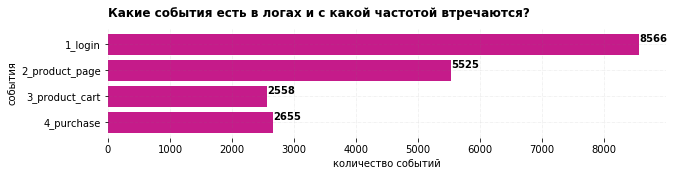

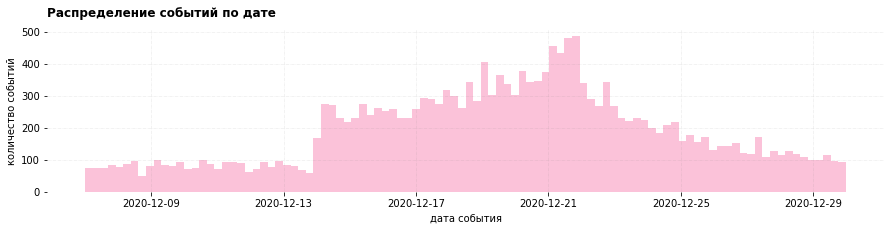

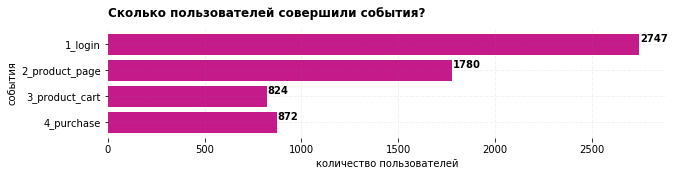

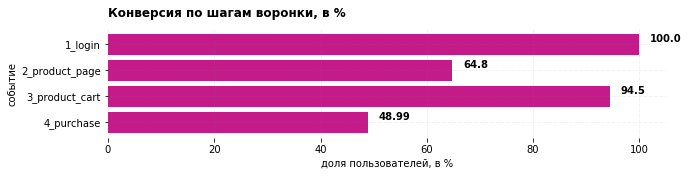

In [14]:
analisys(events_and_users.query('group == "A"'))

Судя по действиям пользователей, можно оплатить товар, бех посещения корзины товаров - поэтому необходимо подумать, нужен ли этот шаг в воронке, или пользователь может обойтись и без него. Кроме этого, судя по конверсии, только порядка 50% клиентов не совершают дальнейшую покупку. Значит, этот шаг не понятен пользователю.

**Группа с новой платежной воронкой B**

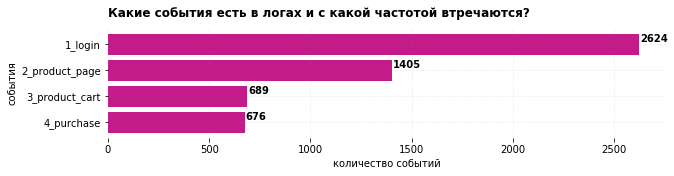

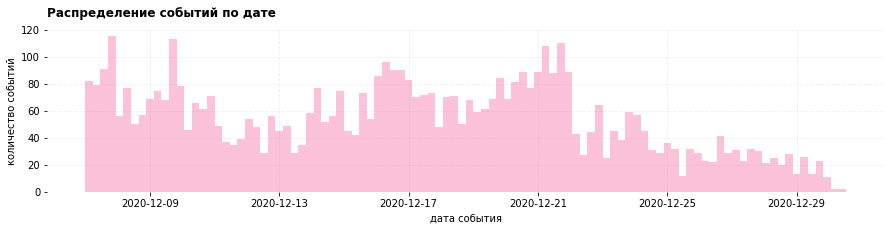

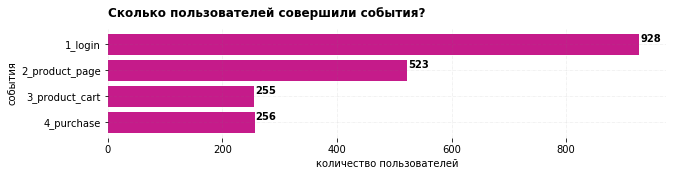

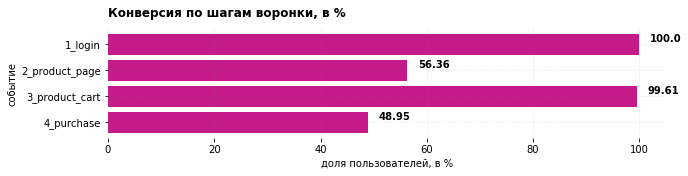

In [15]:
analisys(events_and_users.query('group == "B"'))

Аналогичная ситуация и в контрольной группе - нужно решить целесообразность включения шага перехода пользователя в корзину или его корректировки. Сейчас только меньше половины пользователей оплачивают свой товар в корзине.

Посмотрим, присутствуют ли в выборках одни и те же пользователи:

In [16]:
(events_and_users
                .groupby('user_id')
                .agg({'group': 'nunique'})
                .reset_index()
                .query('group == 2')
                .count()[0])

0

### Влияние маркетинговых событий и второго теста

In [17]:
events.merge(participants, left_on=['user_id'], right_on=['user_id']).groupby('ab_test').agg({'event_dt': 'min'}).reset_index()

,ab_test,event_dt
0,interface_eu_test,2020-12-07 00:02:48
1,recommender_system_test,2020-12-07 00:05:57


Если посмотреть на все проведенные события, можно заметить что данное тестирование проводилось параллельно другому - "interface_eu_test" (из названия теста можно предположить, что проверяли гипотезу об изменении интерфейса интернет-магазина). Конечно же, такое наложение тестов может привести к искажению результатов.

In [18]:
ab_project[ab_project['regions'].str.contains("EU")]

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10


Так как пользователи являются жителями Европы, то я посмотрела только те маркетинговые мероприятия, которые проводились в текущем регионе и во время проведения эксперимента. Оказалось, что одновременно с этим была программа, приуроченная к Рождеству и Новому году. Это может существенно исказить результаты теста.

## Оценка результатов A/B-тестирования

При А/B-тестировании аналитик учитывает, как долго проходил тест. Принимая решение о длительности теста, учитывают циклические изменения трафика.
**ДО проведения эксперимента, необходимо было посмотреть оптимальный размер выборки. Простой способ найти размер выборки — рассчитать в онлайн-калькуляторе.**

Сейчас мы тестируем внедрение улучшенной рекомендательной системы. Текущий уровень конверсии равен 15%. Ожидаемый эффект, который мы хотим обнаружить, равен не менее 10% относительного изменения конверсии. 

Калькулятор говорит, что нам нужно около 9k наблюдений в каждой группе. Зная, что весь трафик равен менее 8.5 за две недели, для проведения теста нужно **более двух недель.**

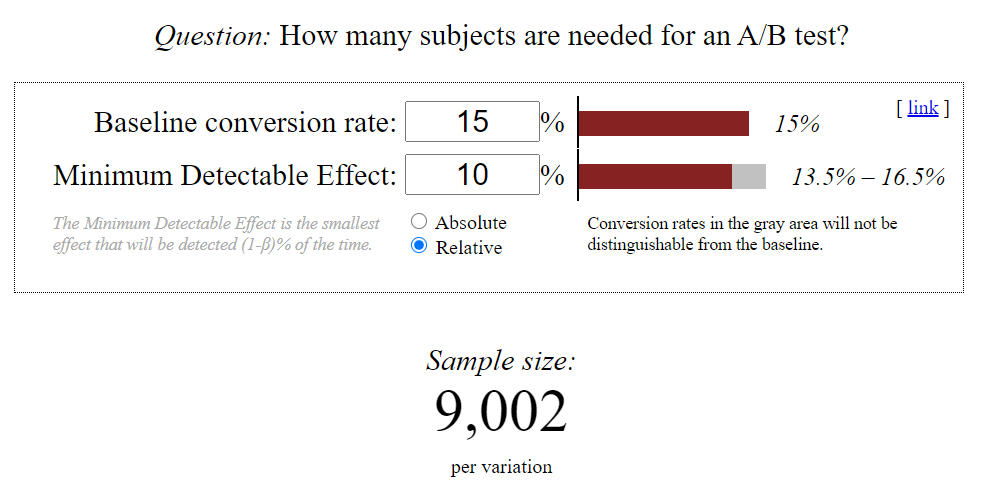

Учитывая влияние следующий факторов на проведение тестирования:
    1. Рождественнские акции;
    2. Проведение параллельного теста на изменение интерфейса интернер-магазина
    
посмотрим статистическую разницу долей z-критерием для каждого шага воронки. Для убодства напишем функцию.

In [19]:
def z_test(successes1, successes2, trials1, trials2, alpha=0.01):
    # пропорция успехов в первой и второй группах:
    p1 = successes1/trials1
    p2 = successes2/trials2

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes1 + successes2) / (trials1 + trials2)

    # разница пропорций в датасетах
    difference = p1 - p2
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print(f'p-значение: {p_value:.3%}')

    if (p_value < alpha):
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')  

In [20]:
users_events_per_group = events_and_users.pivot_table(index='event_name', 
                                                      values='user_id', 
                                                      columns='group', aggfunc=lambda x: x.nunique())

In [21]:
def check_hypithesis(users_events_per_group, gr_count_user, event_name, exp1, exp2):
    
    pr1 = users_events_per_group.loc[event_name, exp1] / gr_count_user.loc[exp1]
    pr2 = users_events_per_group.loc[event_name, exp2] / gr_count_user.loc[exp2]
    print(f'{pr1:.0%} пользователей с событием {event_name} в группе {exp1}')
    print(f'{pr2:.0%} пользователей с событием {event_name} в группе {exp2}')
    
    z_test(users_events_per_group.loc[event_name, exp1],
           users_events_per_group.loc[event_name, exp2],
           gr_count_user.loc[exp1],
           gr_count_user.loc[exp2])

Находят ли статистические критерии разницу между выборками A и B?

**Гипитеза H0 - между экспериментальными группами A и B нет разницы в долях по каждому из событий воронки.**

In [22]:
print('A\A тестирование:\n')
for event_name in users_events_per_group.index:
    check_hypithesis(users_events_per_group, gr_count_user,
                          event_name, 'A', 'B')
    print()

A\A тестирование:

100% пользователей с событием 1_login в группе A
100% пользователей с событием 1_login в группе B
p-значение: nan%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

65% пользователей с событием 2_product_page в группе A
56% пользователей с событием 2_product_page в группе B
p-значение: 0.000%
Отвергаем нулевую гипотезу: между долями есть значимая разница

30% пользователей с событием 3_product_cart в группе A
27% пользователей с событием 3_product_cart в группе B
p-значение: 14.535%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

32% пользователей с событием 4_purchase в группе A
28% пользователей с событием 4_purchase в группе B
p-значение: 1.759%
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



## Итоги

Таким образом, можно сделать вывод о том, что размер выборки и время провередения теста не подходит для получения адекватного результата.

Кроме того, за время проведения тестирования были всплески активности ввиду проведения акции для Рождества и Нового года. А мы знаем, что скидки увеличивают активность аудитории, меняя ее покупательское поведение.

Если посмотреть на все проведенные события, можно заметить что данное тестирование проводилось параллельно другому - "interface_eu_test" (из названия теста можно предположить, что проверяли гипотезу об изменении интерфейса интернет-магазина). Конечно же, такое наложение тестов может привести к искажению результатов.

При этом, есть статистическая значимость между выборками на шаге просмотра карточки товара, что показывает z-тест. Поэтому можно сделать вывод о том, что есть разница между этими шагами в двух группах.